# import Libraries 

In [1]:
import yfinance as yf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, max_error
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Historical Stock Data for Google (GOOGL) from 2015 to 2024

In [2]:
ticker = 'GOOGL' 
data = yf.download(ticker, start='2015-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


# Data Cleaning 

In [3]:
data.shape

(2264, 6)

In [4]:
print(data.isna().sum())

Price      Ticker
Adj Close  GOOGL     0
Close      GOOGL     0
High       GOOGL     0
Low        GOOGL     0
Open       GOOGL     0
Volume     GOOGL     0
dtype: int64


In [5]:
data.duplicated().sum()

0

In [6]:
# select the close price
data = data[['Close']]

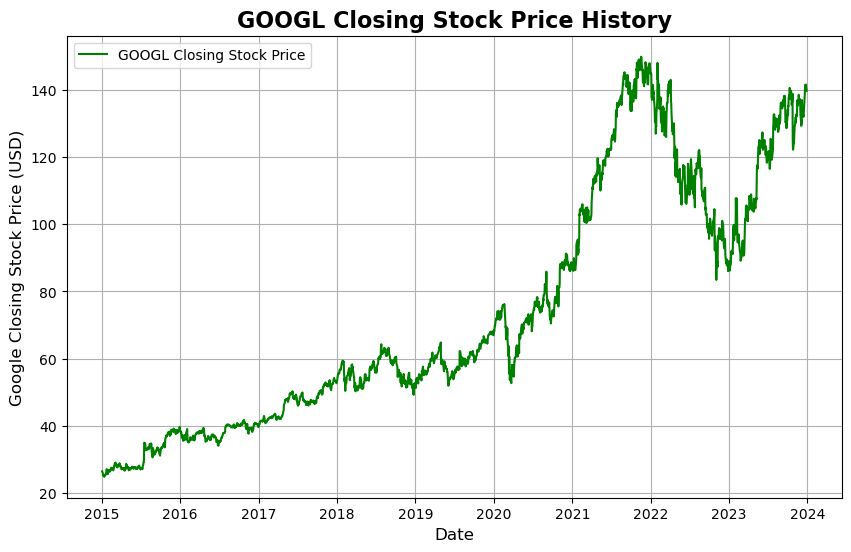

In [7]:
# Plotting the closing prices 
plt.figure(figsize=(10,6))
plt.plot(data['Close'], label='GOOGL Closing Stock Price', color='green')
plt.title('GOOGL Closing Stock Price History', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Google Closing Stock Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Normalizing Stock Data Using Min-Max Scaling

In [8]:
# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data) 

In [9]:
def create_dataset(data, time_step=1): 
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Splitting Data into Training and Testing Sets

In [10]:
time_step = 60 # Use 60 previous days to predict the next day

# Split data into training and testing sets (80% for training, 20% for testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create datasets for training and testing
X_train, y_train = create_dataset(train_data, time_step) 
X_test, y_test = create_dataset(test_data, time_step)

In [11]:
# Reshape input to be [samples, time steps, features] 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Building, Compiling, and Training an LSTM Model for Stock Price Prediction

In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

#Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - loss: 0.0271 - val_loss: 0.0014
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 9.8700e-04 - val_loss: 0.0024
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - loss: 0.0010 - val_loss: 0.0013


In [13]:
#Predict the stock prices
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


In [14]:
# Inverse scaling to get the actual stock prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Model Evaluation metrics for Training and Test Sets

In [15]:
# MSE (Mean Squared Error) for training set
train_mse = mean_squared_error(y_train_actual, train_predict)
print(f"Training Set Mean Squared Error: {train_mse}")

# Max Error for training set
train_max_err = max_error(y_train_actual, train_predict)
print(f"Training Set Max Error: {train_max_err}")

# R² Score for training set
train_r2 = r2_score(y_train_actual, train_predict)
print(f"Training Set R² Score: {train_r2}")


# Evaluate the test set
# MSE (Mean Squared Error) for test set
test_mse = mean_squared_error(y_test_actual, test_predict)
print(f"Test Set Mean Squared Error: {test_mse}")

# Max Error for test set
test_max_err = max_error(y_test_actual, test_predict)
print(f"Test Set Max Error: {test_max_err}")

# R² Score for test set
test_r2 = r2_score(y_test_actual, test_predict)
print(f"Test Set R² Score: {test_r2}")

Training Set Mean Squared Error: 5.498574786171816
Training Set Max Error: 17.64202880859375
Training Set R² Score: 0.994514326600245
Test Set Mean Squared Error: 20.925627719236143
Test Set Max Error: 12.926742553710938
Test Set R² Score: 0.9164855892413188


# Visualizing Google Stock Price Predictions

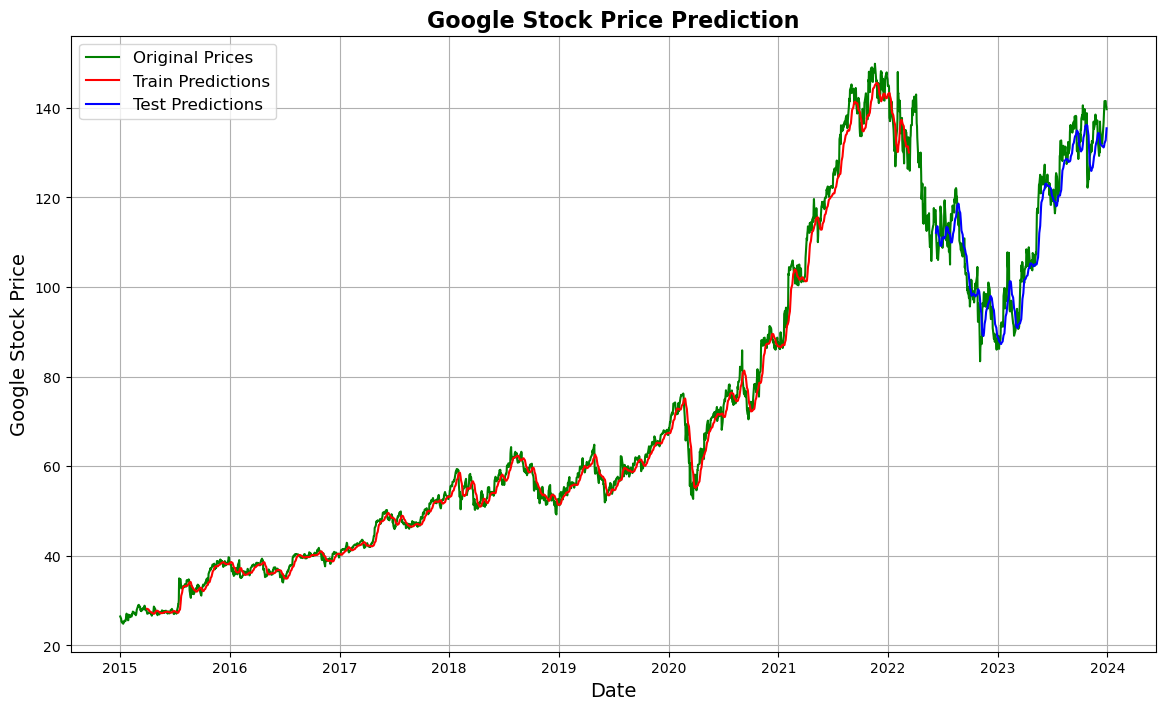

In [16]:
# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(data.index, data, label='Original Prices', color='green') 
plt.plot(data.index[time_step+1:train_size], train_predict, label='Train Predictions', color='red')
plt.plot(data.index[train_size+time_step+1:], test_predict, label='Test Predictions', color='blue') 
plt.xlabel('Date', fontsize=14) 
plt.ylabel('Google Stock Price', fontsize=14) 
plt.legend(loc='upper left', fontsize=12) 
plt.title('Google Stock Price Prediction', fontsize=16, fontweight='bold')
plt.grid(True)
plt.show()